In [1]:
# %%shell
# pip -q install tensorflow-io

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob

try:
  # Use the Colab's preinstalled TensorFlow 2.x
  %tensorflow_version 2.x 
except:
  pass
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_io as tfio

In [2]:
# csv file listing training and validation dataset
dataset_loc = 'F:/SPGC-COVID Dataset'
stats = pd.read_csv(f'{dataset_loc}/Training Dataset/Stats.csv')
stats

,Unnamed: 0,Folder,Category,Diagnosis,Path,Annotation
0,0,P001,Valid,COVID-19,./COVID-19 subjects/,Y
1,1,P002,Valid,COVID-19,./COVID-19 subjects/,Y
2,2,P003,Train,COVID-19,./COVID-19 subjects/,Y
3,3,P004,Train,COVID-19,./COVID-19 subjects/,Y
4,4,P005,Valid,COVID-19,./COVID-19 subjects/,Y
...,...,...,...,...,...,...
302,302,normal072,Train,Normal,./Normal subjects/,N
303,303,normal073,Train,Normal,./Normal subjects/,N
304,304,normal074,Train,Normal,./Normal subjects/,N
305,305,normal075,Valid,Normal,./Normal subjects/,N


In [3]:
# filtering validation and training folder list
def folder_list(category):
  assert category in ['Valid', 'Train', 'Test']
  if category in ['Valid', 'Train']:
    train_dir = f'{dataset_loc}/Training Dataset'
    # filter folder list
    stats_filtered = stats[stats.Category == category]
    folders = [train_dir + stat.Path[1:] + stat.Folder for idx, stat in stats_filtered.iterrows()]
  else: # Test
    test_dir = f'{dataset_loc}/Testing Dataset/SPGC-Test1'
    folders = [test_dir + test for test in os.listdir(test_dir)]
  # 2d list of dcm files
  max_len = 300
  fill = lambda a: a + ['']*(max_len - len(a))
  fetch = lambda a: [x.replace('\\','/') for x in glob.iglob(a)]
  files = [ fill(fetch(folder + '/*.dcm')) for folder in folders ]
  # return as tf dataset
  return tf.data.Dataset.from_tensor_slices(files).shuffle(len(folders))

val_list = folder_list('Valid')
trn_list = folder_list('Train')
tst_list = folder_list('Test')

# example
for f in trn_list.take(1):
  print(f[::len(f)//15])

tf.Tensor(
[b'F:/SPGC-COVID Dataset/Training Dataset/COVID-19 subjects/P136/p137_1.dcm'
 b'F:/SPGC-COVID Dataset/Training Dataset/COVID-19 subjects/P136/p137_117.dcm'
 b'F:/SPGC-COVID Dataset/Training Dataset/COVID-19 subjects/P136/p137_19.dcm'
 b'F:/SPGC-COVID Dataset/Training Dataset/COVID-19 subjects/P136/p137_37.dcm'
 b'F:/SPGC-COVID Dataset/Training Dataset/COVID-19 subjects/P136/p137_55.dcm'
 b'F:/SPGC-COVID Dataset/Training Dataset/COVID-19 subjects/P136/p137_73.dcm'
 b'F:/SPGC-COVID Dataset/Training Dataset/COVID-19 subjects/P136/p137_91.dcm'
 b'' b'' b'' b'' b'' b'' b'' b''], shape=(15,), dtype=string)


In [14]:
tag_slice_loc = tf.constant(tfio.image.dicom_tags.SliceLocation, dtype=tf.uint32)
img_size = [128,128]
empty_val = 1e10
pick_count = 66 # from mid point (max 50, multiple of 6)
pick_offset = pick_count//3
# read and decode dcm files
def get_data(file_path):
  if file_path == '':
    # no file
    slice_loc = tf.constant(empty_val, dtype=tf.dtypes.float32)
    image = tf.zeros(img_size, dtype=tf.float32)
  else:
    # read file
    image_bytes = tf.io.read_file(file_path)
    # decode slice location and image
    slice_loc = tf.strings.to_number(tfio.image.decode_dicom_data(image_bytes, tags=tag_slice_loc))
    # image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16) # non-lossy, keep it commented
    image = tfio.image.decode_dicom_image(image_bytes, scale='auto', on_error='lossy', dtype=tf.float32) # lossy
    image = tf.image.resize(image, img_size) # exp 1
    image = image[0,:,:,0]
  return slice_loc, image

def label_and_process_file(file_paths):
  # extract label from directory
  label = tf.strings.split(file_paths[0], '/')[-3]
  label = tf.math.equal(label, ["COVID-19 subjects", "Cap subjects", "Normal subjects"])
  label = tf.cast(label, tf.float32)
  # read and stack dcm images  
  slice_locs, images = tf.map_fn(lambda i: get_data(file_paths[i]), tf.range(len(file_paths)), fn_output_signature=(tf.float32, tf.float32))
  # sort by slice locations
  sorted_images = tf.gather(tf.transpose(images, [1, 2, 0]), tf.argsort(slice_locs), axis=-1)
  # change May 5
  # take 15 after midpoint
  count = tf.reduce_sum(tf.cast(tf.math.less(slice_locs, empty_val), tf.int32))
  picked_images = tf.slice(sorted_images, [0,0,count//2 - pick_offset], [*img_size,pick_count])
  return picked_images, label

# create dataset object from folder list 
val_ds = val_list.map(label_and_process_file).batch(40).prefetch(1)
trn_ds = trn_list.map(label_and_process_file).batch(40).prefetch(1)
tst_ds = tst_list.map(label_and_process_file).batch(1)

type(trn_ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

Label: [0. 1. 0.]
Raw Image: 


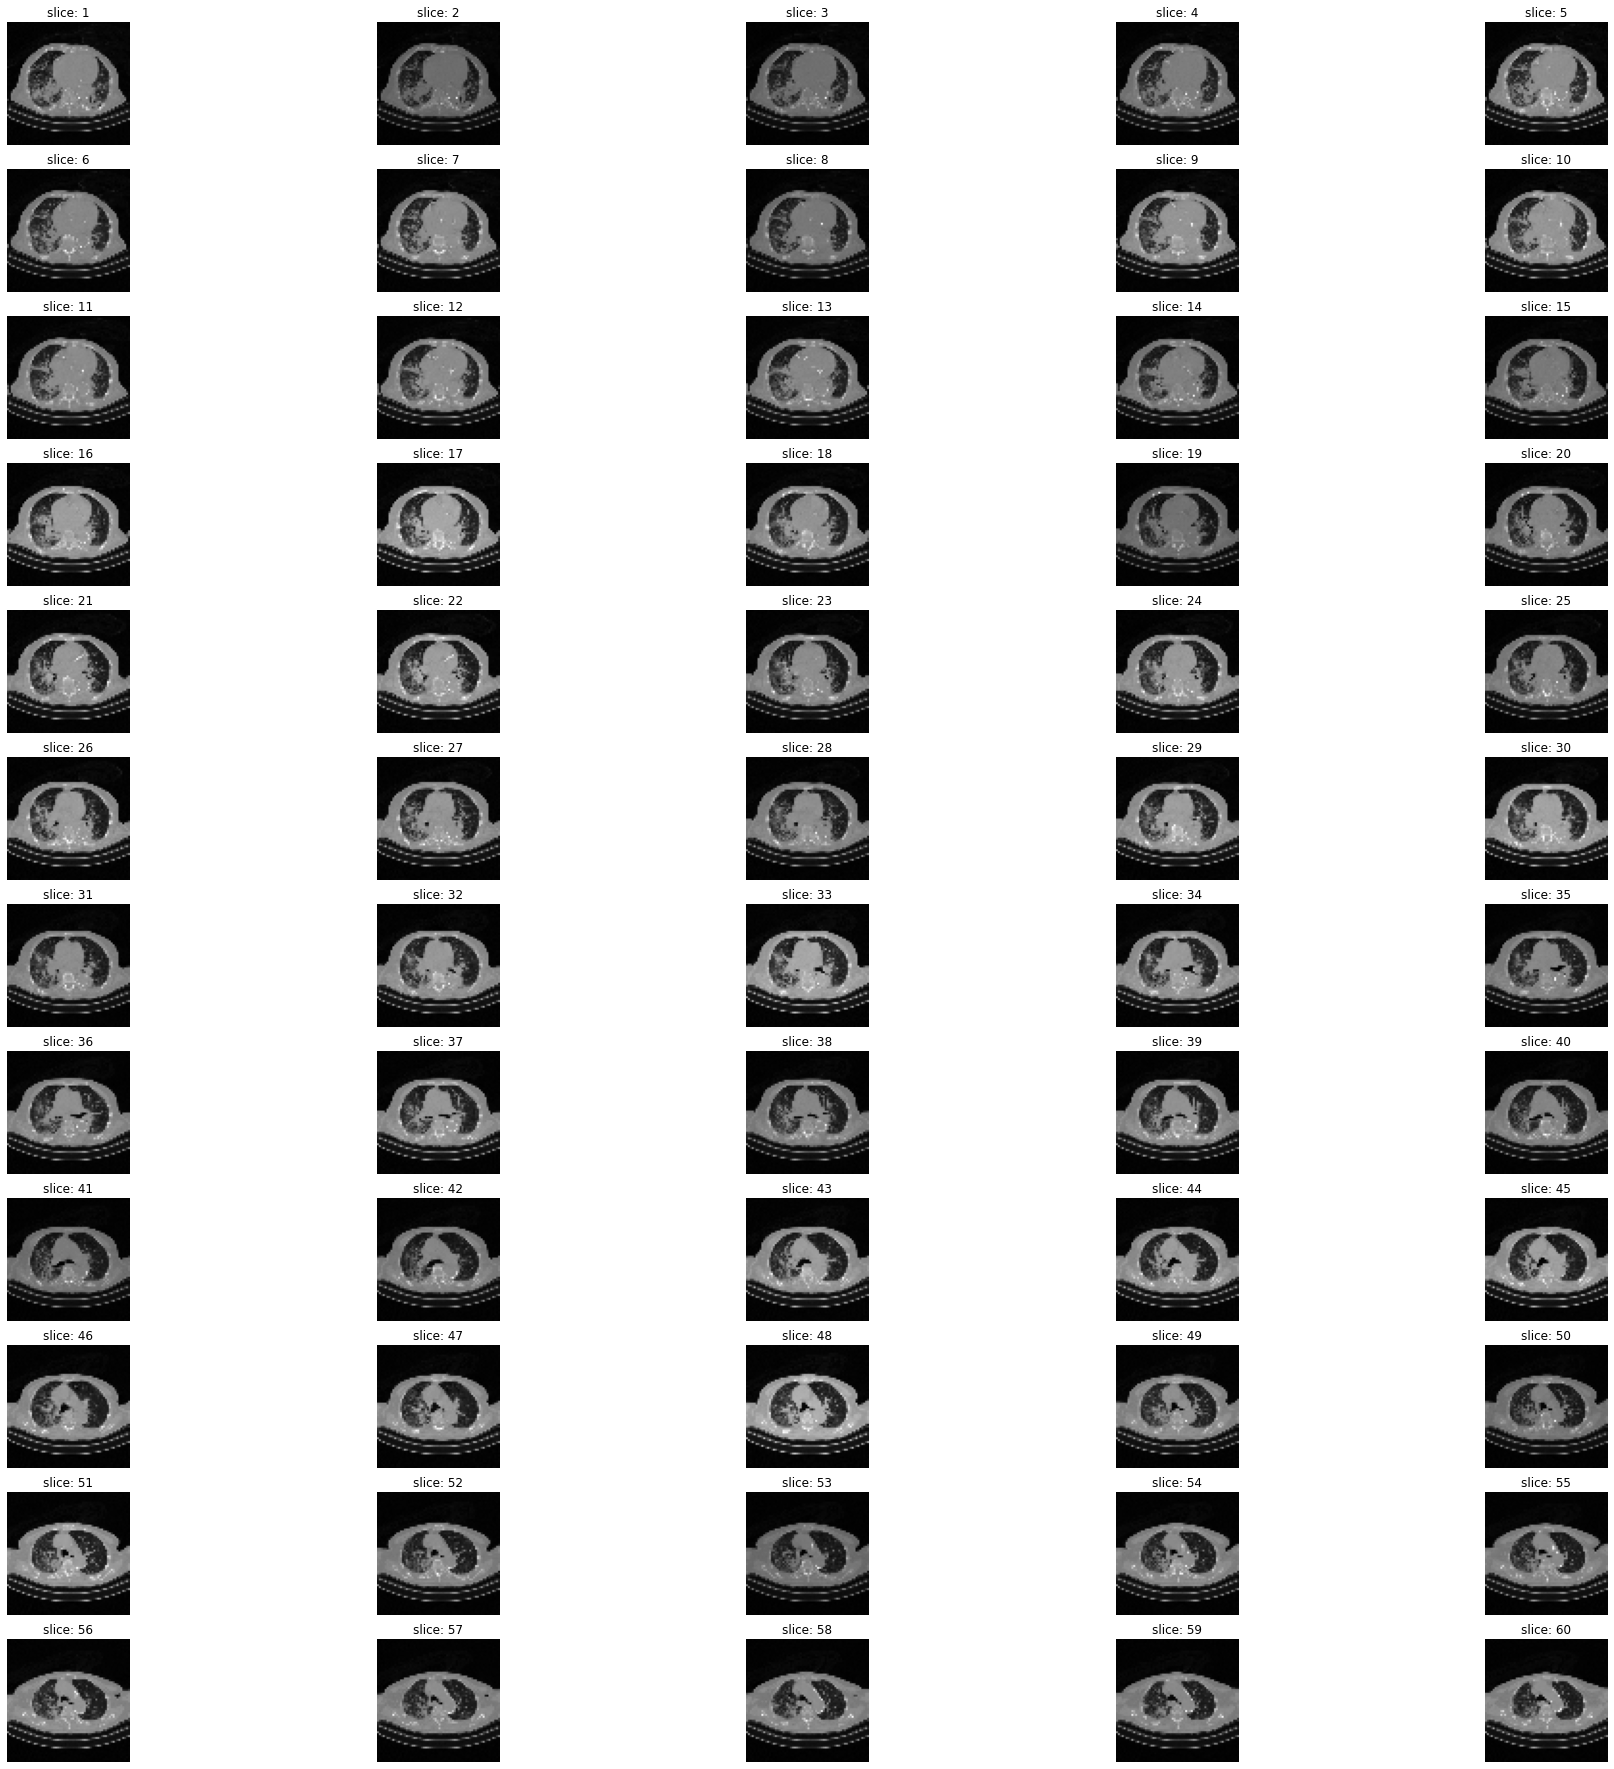

In [41]:
# example
for image_raw, label_text in val_ds.take(1): # change May 5
  print(f'Label: {label_text.numpy()[0]}')
  print(f'Raw Image: ')
  imgs = image_raw.numpy()
  fig = plt.figure(figsize=(32,32))
  cols = 5
  rows = imgs.shape[-1]//cols
  for i in range(rows*cols):
    fig.add_subplot(rows, cols, i+1)
    plt.axis('off')
    plt.imshow(imgs[0,:,:,i], cmap='gray')
    plt.title(f'slice: {i+1}')
  plt.show()



---



In [70]:
# base_model = keras.applications.MobileNetV2(
#     input_shape = [*img_size, 3],
#     include_top = False,
#     weights = 'imagenet'
# )
# base_model.trainable = False

# input_layer = keras.Input(shape=(*img_size, pick_count))
# rescaled = keras.layers.experimental.preprocessing.Rescaling(1./127.5, -1) (input_layer)
# base_layers = [base_model(rescaled[:,:,:,3*k:3*(k+1)]) for k in range(pick_count//3)]
# concat = keras.layers.concatenate(base_layers)
# reshaped = keras.layers.Reshape((4,4,1280*pick_count//3,1))(concat)
# # conv3d = keras.layers.Conv3D(5, (4,4,512), (1,1,512))(reshaped) # change May 5
# flattened = keras.layers.Flatten()(reshaped)
# dense = keras.layers.Dense(100)(flattened)
# output_layer = keras.layers.Dense(3, activation='softmax')(dense)

# model = keras.Model(input_layer, output_layer)
# model.summary()

In [ ]:
# keras.utils.plot_model(model, to_file='F:/model.png')

In [15]:
# change May 5
base_model = keras.applications.Xception(
    input_shape = [*img_size, 3],
    include_top = False,
    weights = 'imagenet'
)
base_model.trainable = False

input_layer = keras.Input(shape=(*img_size, pick_count))
rescaled = keras.layers.experimental.preprocessing.Rescaling(1./127.5, -1) (input_layer)
base_layers = [base_model(rescaled[:,:,:,3*k:3*(k+1)]) for k in range(pick_count//3)]
concat = keras.layers.concatenate(base_layers)
reshaped = keras.layers.Reshape(tuple(concat.shape[1:]) + (1,))(concat)
# conv3d = keras.layers.Conv3D(5, (4,4,512), (1,1,512))(reshaped)
flattened = keras.layers.Flatten()(reshaped)
dense = keras.layers.Dense(100)(flattened)
output_layer = keras.layers.Dense(3, activation='softmax')(dense)

model = keras.Model(input_layer, output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 66 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 128, 128, 66) 0           input_4[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 128, 128, 3)  0           rescaling[0][0]                  
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 128, 128, 3)  0           rescaling[0][0]                  
______________________________________________________________________________________________

In [10]:
inputs = keras.Input((*img_size, pick_count))

x = keras.layers.Reshape((*img_size, pick_count,1))(inputs)
x = keras.layers.Conv3D(filters=32, kernel_size=3, activation="relu")(x)
x = keras.layers.MaxPool3D(pool_size=2)(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
x = keras.layers.MaxPool3D(pool_size=2)(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
x = keras.layers.MaxPool3D(pool_size=2)(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
x = keras.layers.MaxPool3D(pool_size=2)(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.GlobalAveragePooling3D()(x)
x = keras.layers.Dense(units=512, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)

outputs = keras.layers.Dense(units=3, activation="softmax")(x)

# Define the model.
model = keras.Model(inputs, outputs, name="3dcnn")
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 64)]      0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 64, 64, 64, 1)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 62, 62, 62, 32)    896       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 31, 31, 31, 32)    0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 31, 31, 31, 32)    128       
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 29, 29, 29, 64)    55360     
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 14, 14, 14, 64)    0     

In [16]:
model_loc = "E:/Google Drive (SHS)/Colab Notebooks/Saved SPGC models/Xception_imgnet_9"

In [19]:
# def custom_loss(y_true, y_pred):
#     cce = tf.keras.losses.CategoricalCrossentropy()
#     return cce(y_true, y_pred, sample_weight=tf.constant([0.55271565495, 0.19808306709, 0.24920127795]))

model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['acc', keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()],
              weighted_metrics=['acc'])

filepath_val=model_loc + "/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
val_checkpoint = ModelCheckpoint(filepath_val, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
filepath_epoch=model_loc + "/weights-{epoch:02d}.hdf5"
epoch_checkpoint = ModelCheckpoint(filepath_epoch, verbose=0)

model.fit(trn_ds, epochs=50, validation_data=val_ds, class_weight={0:1.81, 1:5.05, 2:4.13}, callbacks=[val_checkpoint, epoch_checkpoint]) # , class_weight={0:0.6, 1:1.33, 2:1.7}

Epoch 1/50
6/6 [==============================] - 171s 25s/step - loss: 4.0218 - acc: 0.3304 - auc_5: 0.4534 - precision_5: 0.1958 - recall_5: 0.0949 - weighted_acc: 0.3038 - val_loss: 1.4311 - val_acc: 0.2449 - val_auc_5: 0.5636 - val_precision_5: 0.2449 - val_recall_5: 0.2449 - val_weighted_acc: 0.2449

Epoch 00001: val_acc improved from -inf to 0.24490, saving model to E:/Google Drive (SHS)/Colab Notebooks/Saved SPGC models/Xception_imgnet_9\weights-improvement-01-0.24.hdf5
Epoch 2/50
6/6 [==============================] - 132s 23s/step - loss: 4.7994 - acc: 0.2486 - auc_5: 0.5437 - precision_5: 0.2474 - recall_5: 0.1948 - weighted_acc: 0.2962 - val_loss: 1.3768 - val_acc: 0.1939 - val_auc_5: 0.5330 - val_precision_5: 0.1939 - val_recall_5: 0.1939 - val_weighted_acc: 0.1939

Epoch 00002: val_acc did not improve from 0.24490
Epoch 3/50
6/6 [==============================] - 133s 23s/step - loss: 3.7889 - acc: 0.1758 - auc_5: 0.4589 - precision_5: 0.1599 - recall_5: 0.1199 - weighted_

In [12]:
# model.load_weights(model_loc + '/weights-05.hdf5')
for imgs, label in val_ds.take(1):
  print(f"GND truth: {label}")
  is_predict = 'y' # input('predict? (y/n): ')
  if is_predict == 'y':
    pred_label = model.predict(imgs)
    print(f"prediction: {pred_label}")
    print(pred_label.argmax(axis=-1))
  else:
    print('terminated')

GND truth: [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
prediction: [[0.3340614  0.3900021  0.27593645]
 [0.3347062  0.38937542 0.27591842]
 [0.33409747 0.39090496 0.27499753]
 [0.33382785 0.38970327 0.2764689 ]
 [0.33385444 0.38923702 0.27690855]
 [0.3348413  0.38933352 0.27582523]
 [0.33390862 0.3888662  0.27722517]
 [0.3343108  0.38977173 0.27591747]
 [0.33477938 0.38903683 0.27618375]
 [0.3343801  0.39010108 0.2755188 ]
 [0.33411765 0.38946047 0.2764219 ]
 [0.33466643 0.38954318 0.27579042]
 [0.33441624 0.38995743 0.2756263 ]
 [0.334827   0.38993397 0.27